<a href="https://colab.research.google.com/github/ravi-gopalan/ds_bowl/blob/master/DS_bowl_OOP_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
cd /root

/root


In [0]:
!mkdir .kaggle

In [0]:
!cp '/gdrive/My Drive/Colab_stuff/kaggle.json' '/root/.kaggle/kaggle.json' 
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
cd /content/

/content


In [0]:
!mkdir data_science_bowl_2019

In [7]:
cd data_science_bowl_2019

/content/data_science_bowl_2019


In [8]:
!kaggle competitions download -c data-science-bowl-2019

 81% 33.0M/40.8M [00:01<00:01, 7.25MB/s]
100% 40.8M/40.8M [00:01<00:00, 26.5MB/s]
  0% 0.00/262k [00:00<?, ?B/s]
100% 262k/262k [00:00<00:00, 78.0MB/s]
  0% 0.00/399k [00:00<?, ?B/s]
100% 399k/399k [00:00<00:00, 118MB/s]
  0% 0.00/10.8k [00:00<?, ?B/s]
100% 10.8k/10.8k [00:00<00:00, 21.5MB/s]
100% 397M/397M [00:08<00:00, 82.0MB/s]



In [9]:
!ls

sample_submission.csv  test.csv.zip   train_labels.csv.zip
specs.csv	       train.csv.zip


In [10]:
!unzip train_labels.csv.zip
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train_labels.csv.zip
  inflating: train_labels.csv        
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
!pip install category_encoders
!pip install catboost

In [0]:
import pandas as pd
import numpy as np
from typing import Any
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

import gc
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from category_encoders.ordinal import OrdinalEncoder
import catboost as cat
from catboost import CatBoostRegressor, CatBoostClassifier

from joblib import Parallel, delayed
from collections import defaultdict
import copy

import time
from numba import jit

from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [0]:
base_dir = '/content/data_science_bowl_2019/'

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def ifnone(a: Any, b: Any) -> Any:
    """`a` if `a` is not None, otherwise `b`.
    from fastai: https://github.com/fastai/fastai/blob/master/fastai/core.py#L92"""
    return b if a is None else a



def add_datepart(df: pd.DataFrame, field_name: str,
                 prefix: str = None, drop: bool = True, time: bool = True, date: bool = True):
    """
    Helper function that adds columns relevant to a date in the column `field_name` of `df`.
    from fastai: https://github.com/fastai/fastai/blob/master/fastai/tabular/transform.py#L55
    """
    field = df[field_name]
    prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start']
    if date:
        attr.append('Date')
    if time:
        attr = attr + ['Hour', 'Minute']
    for n in attr:
        df[prefix + n] = getattr(field.dt, n.lower())
    if drop:
        df.drop(field_name, axis=1, inplace=True)
    return df

def extract_time_features(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['year'] = df['timestamp'].dt.year
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['weekofyear'] = df['timestamp'].dt.weekofyear
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['quarter'] = df['timestamp'].dt.quarter
    df['is_month_start'] = df['timestamp'].dt.is_month_start
    df['is_month_end'] = df['timestamp'].dt.is_month_end 
    return df

def read_data():
    print(f'Read data')
    train_df = pd.read_csv(f'{base_dir}train.csv')
   
    test_df = pd.read_csv(base_dir+'test.csv')
    train_labels_df = pd.read_csv(base_dir+'train_labels.csv')
    specs_df = pd.read_csv(base_dir+'specs.csv')
    sample_submission_df = pd.read_csv(base_dir+'sample_submission.csv')
    
    return train_df, test_df, train_labels_df, specs_df, sample_submission_df

In [0]:
@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


In [15]:
train_df, test_df, train_labels_df, specs_df, sample_submission_df = read_data()

df_list = [train_df, test_df, train_labels_df, specs_df, sample_submission_df]
df_names = ['train_df','test_df', 'train_labels_df', 'specs_df', 'sample_submission_df']
for name, df in zip(df_names, df_list):
  print(f'Shrinking {name}')
  df = reduce_mem_usage(df)

Read data
Shrinking train_df
Mem. usage decreased to 778.73 Mb (18.2% reduction)
Shrinking test_df
Mem. usage decreased to 79.40 Mb (18.2% reduction)
Shrinking train_labels_df
Mem. usage decreased to  0.49 Mb (48.2% reduction)
Shrinking specs_df
Mem. usage decreased to  0.01 Mb (0.0% reduction)
Shrinking sample_submission_df
Mem. usage decreased to  0.01 Mb (43.4% reduction)


In [16]:
!pip install category_encoders

     |████████████████████████████████| 102kB 6.4MB/s 


In [19]:
title_oe = OrdinalEncoder()
title_oe.fit(list(set(train_df['title'].unique()).union(set(test_df['title'].unique()))))

world_oe = OrdinalEncoder()
world_oe.fit(list(set(train_df['world'].unique()).union(set(test_df['world'].unique()))))  

OrdinalEncoder(cols=[0], drop_invariant=False, handle_missing='value',
               handle_unknown='value',
               mapping=[{'col': 0, 'data_type': dtype('O'),
                         'mapping': NONE            1
CRYSTALCAVES    2
MAGMAPEAK       3
TREETOPCITY     4
NaN            -2
dtype: int64}],
               return_df=True, verbose=0)

In [0]:
def add_attempts_corrects(df, title_oe, world_oe):
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df['attempt'] = 0
  df.loc[(df['title'] == 'Bird Measurer (Assessment)') & (df['event_code'] == 4110), 'attempt'] = 1
  df.loc[(df['type'] == 'Assessment') & (df['title'] != 'Bird Measurer (Assessment)') & (df['event_code'] == 4100), 'attempt'] = 1

  df['correct'] = None
  df.loc[(df['attempt'] == 1) & (df['event_data'].str.contains('"correct":true')), 'correct'] = True
  df.loc[(df['attempt'] == 1) & (df['event_data'].str.contains('"correct":false')), 'correct'] = False

  df['title'] = title_oe.transform(df['title'].values)
  df['world'] = world_oe.transform(df['world'].values)
  return df

In [0]:
train_df = add_attempts_corrects(train_df, title_oe, world_oe)
test_df = add_attempts_corrects(test_df, title_oe, world_oe)

train_df = train_df.loc[train_df['installation_id'].isin(train_labels_df['installation_id'].unique())]

In [23]:
!pip install catboost

     |████████████████████████████████| 63.6MB 78.8MB/s 


In [0]:
class CatWrapper(object):
    """
    A wrapper for catboost model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = cat.CatBoostClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        self.model = self.model.set_params(**{k: v for k, v in params.items() if k != 'cat_cols'})

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = None
        else:
            categorical_columns = None
        
        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       cat_features=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if 'MultiClass' not in self.model.get_param('loss_function'):
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, ntree_end=self.model.best_iteration_)



In [0]:
class ClassifierModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='auc',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 4# 1 if len(set(y.values)) == 2 else len(set(y.values))
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)
            # y = X['accuracy_group']

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):
            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict_proba(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(float)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=25)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            g = sns.heatmap(confusion_matrix(y, self.oof.argmax(1)), annot=True, cmap=plt.cm.Blues,fmt="d")
            g.set(ylim=(-0.5, 4), xlim=(-0.5, 4), title='Confusion matrix')

            plt.subplot(2, 2, 4)
            plt.hist(self.oof.argmax(1))
            plt.xticks(range(self.n_target), range(self.n_target))
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]
            self.cols_to_drop = cols_to_drop
            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
            X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict_proba(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        full_evals_results[self.eval_metric] = np.abs(full_evals_results[self.eval_metric])
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')

In [0]:
class FeatureGenerator(object):
    def __init__(self, n_jobs=1, df=None, dataset: str = 'train'):
        self.n_jobs = n_jobs
        self.df = df
        self.dataset = dataset

    def read_chunks(self):
        for id, user_sample in self.df.groupby('installation_id', sort=False):
            yield id, user_sample

    def get_features(self, row):
        """
        Gets three groups of features: from original data and from reald and imaginary parts of FFT.
        """
        return self.features(row)

    def features(self, id, user_sample):
        user_data = []

        accuracy_mapping = {0: 0, 1: 3, 0.5: 2}

        user_stats = defaultdict(int)
        user_stats['installation_id'] = user_sample['installation_id'].unique()[0]
        user_stats['world'] = user_sample['world'].unique()[0]
        user_stats['timestamp'] = user_sample['timestamp'].unique()[0]

        temp_dict = defaultdict(int)
        another_temp_dict = {}
        another_temp_dict['durations'] = []
        another_temp_dict['all_durations'] = []
        another_temp_dict['durations_with_attempts'] = []
        another_temp_dict['mean_action_time'] = []
        title_data = defaultdict(dict)

        for i, session in user_sample.groupby('game_session', sort=False):
            user_stats['last_ass_session_game_time'] = another_temp_dict['durations'][-1] if len(another_temp_dict['durations']) > 0 else 0
            user_stats['last_session_game_time'] = another_temp_dict['all_durations'][-1] if len(another_temp_dict['all_durations']) > 0 else 0

            # calculate some user_stats and append data
            if session['attempt'].sum() > 0 or self.dataset == 'test':
                user_stats['session_title'] = session['title'].values[0]
                accuracy = np.nan_to_num(session['correct'].sum() / session['attempt'].sum())
                if accuracy in accuracy_mapping.keys():
                    user_stats['accuracy_group'] = accuracy_mapping[accuracy]
                else:
                    user_stats['accuracy_group'] = 1
                user_stats['accumulated_accuracy_group'] = temp_dict['accumulated_accuracy_group'] / user_stats['counter'] if user_stats['counter'] > 0 else 0
                temp_dict['accumulated_accuracy_group'] += user_stats['accuracy_group']
                user_data.append(copy.copy(user_stats))

            user_stats[session['type'].values[-1]] += 1
            user_stats['accumulated_correct_attempts'] += session['correct'].sum()
            user_stats['accumulated_uncorrect_attempts'] += session['attempt'].sum() - session['correct'].sum()
            event_code_counts = session['event_code'].value_counts()
            for i, j in zip(event_code_counts.index, event_code_counts.values):
                user_stats[i] += j

            temp_dict['assessment_counter'] += 1
            if session['title'].values[-1] in title_data.keys():
                pass
            else:
                title_data[session['title'].values[-1]] = defaultdict(int)

            title_data[session['title'].values[-1]]['duration_all'] += session['game_time'].values[-1]
            title_data[session['title'].values[-1]]['counter_all'] += 1
            #user_stats['duration'] += (session['timestamp'].values[-1] - session['timestamp'].values[0]) / np.timedelta64(1, 's')

            user_stats['duration'] = (session.iloc[-1,2] - session.iloc[0,2]).seconds
            if session['type'].values[0] == 'Assessment' and (len(session) > 1 or self.dataset == 'test'):
                another_temp_dict['durations'].append(user_stats['duration'])
                accuracy = np.nan_to_num(session['correct'].sum() / session['attempt'].sum())
                user_stats['accumulated_accuracy_'] += accuracy
                user_stats['counter'] += 1
                if user_stats['counter'] == 0:
                    user_stats['accumulated_accuracy'] = 0
                else:
                    user_stats['accumulated_accuracy'] = user_stats['accumulated_accuracy_'] / user_stats['counter']

                accuracy = np.nan_to_num(session['correct'].sum() / session['attempt'].sum())

                if accuracy in accuracy_mapping.keys():
                    user_stats[accuracy_mapping[accuracy]] += 1
                else:
                    user_stats[1] += 1

                user_stats['accumulated_actions'] += len(session)

                if session['attempt'].sum() > 0:
                    user_stats['sessions_with_attempts'] += 1
                    another_temp_dict['durations_with_attempts'].append(user_stats['duration'])

                if session['correct'].sum() > 0:
                    user_stats['sessions_with_correct_attempts'] += 1
                    
                user_stats['title_duration'] = title_data[session['title'].values[-1]]['duration']
                user_stats['title_counter'] = title_data[session['title'].values[-1]]['counter']
                user_stats['title_mean_duration'] = user_stats['title_duration'] / user_stats['title_mean_duration']  if user_stats['title_mean_duration'] > 0 else 0

                user_stats['title_duration_all'] = title_data[session['title'].values[-1]]['duration_all']
                user_stats['title_counter_all'] = title_data[session['title'].values[-1]]['counter_all']
                user_stats['title_mean_duration_all'] = user_stats['title_duration_all'] / user_stats['title_mean_duration_all']  if user_stats['title_mean_duration_all'] > 0 else 0
                
                title_data[session['title'].values[-1]]['duration'] += session['game_time'].values[-1]
                title_data[session['title'].values[-1]]['counter'] += 1

            elif (len(session) > 1 or self.dataset == 'test'):
                another_temp_dict['all_durations'].append(user_stats['duration'])


            if user_stats['duration'] != 0:
                temp_dict['nonzero_duration_assessment_counter'] += 1
            #user_stats['duration_mean'] = user_stats['duration'] / max(temp_dict['nonzero_duration_assessment_counter'], 1)
            # stats from assessment sessions
            user_stats['duration_mean'] = np.mean(another_temp_dict['durations'])
            user_stats['duration_attempts'] = np.mean(another_temp_dict['durations_with_attempts'])

            # stats from all sessions
            user_stats['all_duration_mean'] = np.mean(another_temp_dict['all_durations'])
            user_stats['all_accumulated_actions'] += len(session)
            user_stats['mean_action_time'] = np.mean(another_temp_dict['mean_action_time'])
            another_temp_dict['mean_action_time'].append(session['game_time'].values[-1] / len(session))


        if self.dataset == 'test':
            user_data = [user_data[-1]]

        return user_data

    def generate(self):
        feature_list = []
#         res = Parallel(n_jobs=self.n_jobs, backend='threading')(delayed(self.features)(id, user_sample)
#                                                                 for id, user_sample in tqdm(self.read_chunks(),
#                                                                                             total=self.df[
#                                                                                                 'installation_id'].nunique()))
        res = Parallel(n_jobs=self.n_jobs, backend='threading')(delayed(self.features)(id, user_sample)
                                                                for id, user_sample in self.read_chunks())
        for r in res:
            for r1 in r:
                feature_list.append(r1)
        return pd.DataFrame(feature_list)

In [29]:
%%time
fg = FeatureGenerator(n_jobs=2, df=train_df)
data = fg.generate()
data = data.fillna(0)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in long_scalars


CPU times: user 7min 50s, sys: 27.3 s, total: 8min 17s
Wall time: 7min 34s


In [32]:
del train_df
gc.collect()

508

In [0]:
class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)

        data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
        data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
        data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

        data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


In [0]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, cat_cols=None, drop_original: bool = False, encoder=OrdinalEncoder()):
        """
        Categorical transformer. This is a wrapper for categorical encoders.

        :param cat_cols:
        :param drop_original:
        :param encoder:
        """
        self.cat_cols = cat_cols
        self.drop_original = drop_original
        self.encoder = encoder
        self.default_encoder = OrdinalEncoder()

    def fit(self, X, y=None):

        if self.cat_cols is None:
            kinds = np.array([dt.kind for dt in X.dtypes])
            is_cat = kinds == 'O'
            self.cat_cols = list(X.columns[is_cat])
        self.encoder.set_params(cols=self.cat_cols)
        self.default_encoder.set_params(cols=self.cat_cols)

        self.encoder.fit(X[self.cat_cols], y)
        self.default_encoder.fit(X[self.cat_cols], y)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        new_cat_names = [f'{col}_encoded' for col in self.cat_cols]
        encoded_data = self.encoder.transform(data[self.cat_cols])
        if encoded_data.shape[1] == len(self.cat_cols):
            data[new_cat_names] = encoded_data
        else:
            pass

        if self.drop_original:
            data = data.drop(self.cat_cols, axis=1)
        else:
            data[self.cat_cols] = self.default_encoder.transform(data[self.cat_cols])

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [0]:
class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

        self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
                         or 'attempt' in col]

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [0]:
cat_cols = ['world']
mt = MainTransformer(create_interactions=False)
ct = CategoricalTransformer(drop_original=True, cat_cols=cat_cols)
ft = FeatureTransformer()
transformers = {'ft': ft, 'ct': ct}

In [37]:
data = add_datepart(data, 'timestamp', drop=False)
data = reduce_mem_usage(data)
y = data['accuracy_group']

Mem. usage decreased to  3.39 Mb (70.9% reduction)


In [38]:
# getting constant columns
bad_cols = []
for col in data:
    if data[col].nunique() <= 1:
        print(col)
        bad_cols.append(col)


cols_to_drop = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate'] + bad_cols

data.columns = [str(col) for col in data.columns]

title_mean_duration
title_mean_duration_all
timestampYear


In [0]:
cat_params = {'loss_function': 'MultiClass',
          'eval_metric':"WKappa",
          'task_type': "CPU",
          'iterations': 2000,
          'learning_rate': 0.01,
          'verbose': 500,
          'early_stopping_rounds': 100,
          'cat_cols': ['world_encoded', 'session_title'],
          'od_type': 'Iter',
          'early_stopping_rounds': 200
    }

In [0]:
folds = GroupKFold(n_splits=5)

Fold 1 started at Sat Nov 30 09:25:18 2019
0:	learn: 0.4522516	test: 0.4562965	test1: 0.4602028	best: 0.4602028 (0)	total: 177ms	remaining: 5m 54s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5142268032
bestIteration = 1

Shrink model to first 2 iterations.
Fold 2 started at Sat Nov 30 09:25:39 2019
0:	learn: 0.4207412	test: 0.4556531	test1: 0.4627095	best: 0.4627095 (0)	total: 105ms	remaining: 3m 29s
500:	learn: 0.5090970	test: 0.5101197	test1: 0.5147377	best: 0.5147377 (500)	total: 49.1s	remaining: 2m 26s
1000:	learn: 0.5332299	test: 0.5337229	test1: 0.5225096	best: 0.5238728 (979)	total: 1m 38s	remaining: 1m 37s
1500:	learn: 0.5595223	test: 0.5577216	test1: 0.5304931	best: 0.5308424 (1491)	total: 2m 27s	remaining: 49.2s
1999:	learn: 0.5715971	test: 0.5713281	test1: 0.5402508	best: 0.5419745 (1932)	total: 3m 16s	remaining: 0us

bestTest = 0.5419745178
bestIteration = 1932

Shrink model to first 1933 iterations.
Fold 3 started at Sat Nov 30 09:28:56 2019
0:	lea

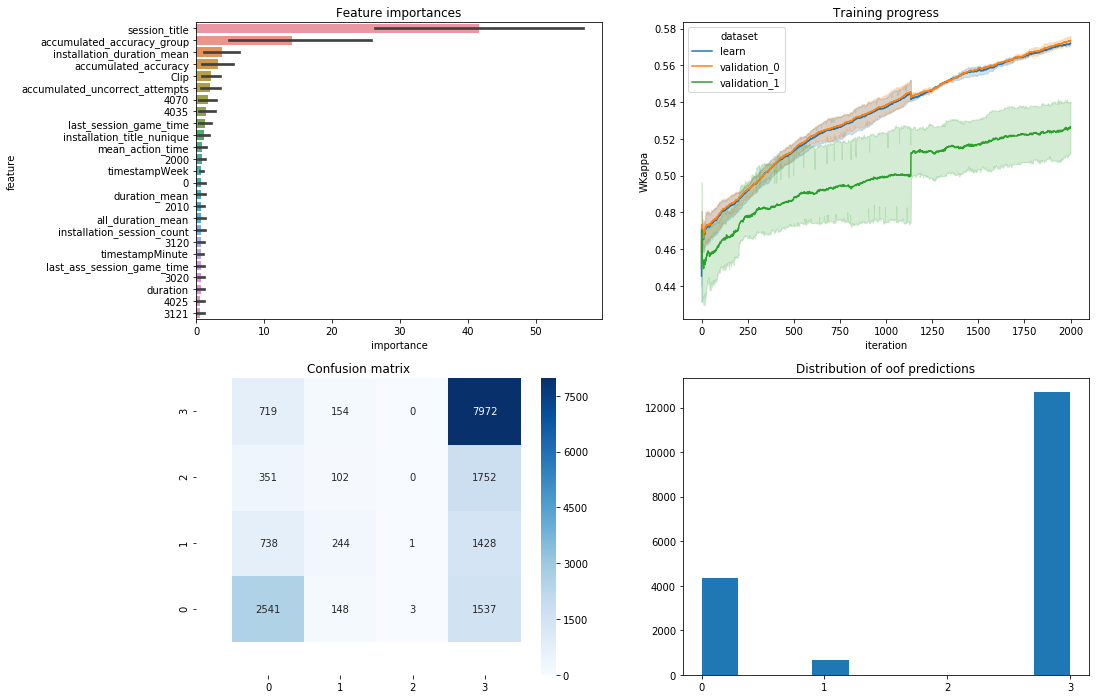

In [43]:
cat_model = ClassifierModel(model_wrapper=CatWrapper())
cat_model.fit(X=data, y=y, folds=folds, params=cat_params, preprocesser=mt, transformers=transformers,
              eval_metric='WKappa', cols_to_drop=cols_to_drop)

In [44]:
%%time
fg = FeatureGenerator(n_jobs=2, df=test_df, dataset='test')
test_data = fg.generate()
test_data.columns = [str(col) for col in test_data.columns]
test_data = test_data.fillna(0)
test_data = add_datepart(test_data, 'timestamp', drop=False)

CPU times: user 1min 25s, sys: 4.72 s, total: 1min 29s
Wall time: 1min 21s


In [0]:
prediction = cat_model.predict(test_data)

In [46]:
prediction

array([[0.16378033, 0.15427156, 0.19796243, 0.48398569],
       [0.15060274, 0.16469357, 0.18365474, 0.50104894],
       [0.19384419, 0.13794968, 0.16440869, 0.50379744],
       ...,
       [0.21268266, 0.18695785, 0.19678919, 0.4035703 ],
       [0.28381825, 0.14821276, 0.17361082, 0.39435818],
       [0.21162525, 0.30992998, 0.19984312, 0.27860164]])

In [0]:
sample_submission_df['accuracy_group'] = prediction.argmax(1)
sample_submission_df.to_csv('submission.csv', index=False)